# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import math
from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.395765
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *There are 10 classes and each of those classes are equally likely. So probability of correct class would be 0.1. Since, loss is defined as negative log over correct class probability. Thus, loss should be approximately -log(0.1) *

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 5.155238 analytic: 5.155238, relative error: 8.980402e-09
numerical: -0.972751 analytic: -0.972751, relative error: 1.547655e-08
numerical: 1.568238 analytic: 1.568238, relative error: 7.725635e-09
numerical: -0.663710 analytic: -0.663710, relative error: 9.208082e-08
numerical: -1.631875 analytic: -1.631875, relative error: 5.146584e-09
numerical: 0.205496 analytic: 0.205497, relative error: 4.119656e-08
numerical: 0.011554 analytic: 0.011554, relative error: 3.901106e-06
numerical: -0.779540 analytic: -0.779540, relative error: 8.634422e-09
numerical: -5.030244 analytic: -5.030244, relative error: 1.161248e-08
numerical: -3.245344 analytic: -3.245344, relative error: 2.299549e-08
numerical: 0.981578 analytic: 0.981578, relative error: 3.191370e-08
numerical: -0.413178 analytic: -0.413178, relative error: 7.411750e-08
numerical: -2.101176 analytic: -2.101176, relative error: 1.235928e-08
numerical: 1.209351 analytic: 1.209351, relative error: 1.333335e-08
numerical: -0.0244

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.395765e+00 computed in 0.198829s
vectorized loss: 2.395765e+00 computed in 0.015622s
Loss difference: 0.000000
Gradient difference: 0.000000


In [8]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

learning_rates_loop = np.linspace(learning_rates[0],learning_rates[1],5)
regularization_strengths_loop = np.arange(regularization_strengths[0],regularization_strengths[1],1000)

i = 0

for learning_rate in learning_rates_loop:
    for regularization_strength in regularization_strengths_loop:
        print ("index:", i, "learning_rate:", learning_rate, "regularization_strength:", regularization_strength)
        i += 1
        results[(learning_rate,regularization_strength)] = ()
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                      num_iters=1500, verbose=False)
        
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)        
        results[(learning_rate,regularization_strength)] = (np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred))
        
        if np.mean(y_val == y_val_pred) > best_val:
            best_softmax = softmax
            best_val = np.mean(y_val == y_val_pred)
        
        print (np.mean(y_val == y_val_pred))

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

index: 0 learning_rate: 1e-07 regularization_strength: 25000.0
0.339
index: 1 learning_rate: 1e-07 regularization_strength: 26000.0
0.34
index: 2 learning_rate: 1e-07 regularization_strength: 27000.0
0.328
index: 3 learning_rate: 1e-07 regularization_strength: 28000.0
0.346
index: 4 learning_rate: 1e-07 regularization_strength: 29000.0
0.341
index: 5 learning_rate: 1e-07 regularization_strength: 30000.0
0.334
index: 6 learning_rate: 1e-07 regularization_strength: 31000.0
0.336
index: 7 learning_rate: 1e-07 regularization_strength: 32000.0
0.337
index: 8 learning_rate: 1e-07 regularization_strength: 33000.0
0.332
index: 9 learning_rate: 1e-07 regularization_strength: 34000.0
0.329
index: 10 learning_rate: 1e-07 regularization_strength: 35000.0
0.329
index: 11 learning_rate: 1e-07 regularization_strength: 36000.0
0.328
index: 12 learning_rate: 1e-07 regularization_strength: 37000.0
0.32
index: 13 learning_rate: 1e-07 regularization_strength: 38000.0
0.329
index: 14 learning_rate: 1e-07 r

0.317
index: 118 learning_rate: 5e-07 regularization_strength: 43000.0
0.323
index: 119 learning_rate: 5e-07 regularization_strength: 44000.0
0.318
index: 120 learning_rate: 5e-07 regularization_strength: 45000.0
0.317
index: 121 learning_rate: 5e-07 regularization_strength: 46000.0
0.317
index: 122 learning_rate: 5e-07 regularization_strength: 47000.0
0.323
index: 123 learning_rate: 5e-07 regularization_strength: 48000.0
0.321
index: 124 learning_rate: 5e-07 regularization_strength: 49000.0
0.328
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.326551 val accuracy: 0.339000
lr 1.000000e-07 reg 2.600000e+04 train accuracy: 0.323469 val accuracy: 0.340000
lr 1.000000e-07 reg 2.700000e+04 train accuracy: 0.328082 val accuracy: 0.328000
lr 1.000000e-07 reg 2.800000e+04 train accuracy: 0.330000 val accuracy: 0.346000
lr 1.000000e-07 reg 2.900000e+04 train accuracy: 0.321429 val accuracy: 0.341000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.321449 val accuracy: 0.334000
lr 1.000000

In [9]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.353000


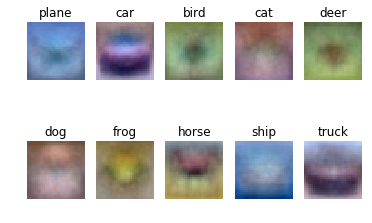

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])